In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statistics import mode
from sklearn.cluster import KMeans

In [86]:
df = pd.read_csv('../data/train.csv')

In [87]:
df = df.sort_values(['locdt', 'loctm'])

In [89]:
df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
498036,6716,12765,101514,966.58,4,62,N,2,N,N,...,2,1,29.0,247,34949,N,5817,102,0,1119159
900910,5575,34837,60869,1071.10,5,62,Y,8,N,N,...,0,1,40.0,203,33794,N,2138,44,0,641444
1429123,6769,22630,110573,438.21,5,62,N,5,N,N,...,0,1,45.0,251,79257,N,3588,102,0,188670
739925,6767,91588,208961,1174.17,5,62,N,5,N,N,...,0,1,48.0,293,14765,N,5817,102,0,1475737
434529,3198,84148,180103,367.29,5,60,N,5,N,N,...,0,1,51.0,251,68966,N,3982,38,0,641443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,62,Y,2,N,N,...,0,90,235916.0,248,84802,N,5817,102,0,325840
1502777,5720,152795,151050,287.02,5,62,Y,8,N,N,...,0,90,235922.0,295,67613,N,5758,92,0,784237
577420,6777,3324,171229,625.35,5,62,Y,8,N,N,...,0,90,235953.0,257,2572,Y,5817,102,0,1459862
1034666,3348,150457,143382,277.55,5,62,Y,8,N,N,...,0,90,235957.0,289,54828,N,3460,46,0,784238


In [95]:
# filter > 19 筆交易紀錄 for 卡號
card_tx_hist = {}

for idx, row in tqdm(df[df["fraud_ind"] == 0].iterrows()):
    cano = row["cano"]
    if cano in card_tx_hist:
        card_tx_hist[cano].append(idx)
    else:
        card_tx_hist[cano] = [idx]

0it [00:00, ?it/s]

In [96]:
tx_sample = []

for k, v in tqdm(card_tx_hist.items()):
    if len(v) > 17:
        card_tx_hist[k] = v[int(len(v) * 0.3) : ]
    tx_sample += card_tx_hist[k]

  0%|          | 0/128439 [00:00<?, ?it/s]

In [97]:
sample_df = df.loc[tx_sample]

In [98]:
conam_pct = df.loc[:,['cano','conam']].groupby('cano').mean()

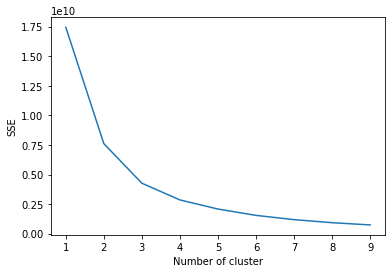

In [56]:
sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(conam_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [99]:
kmeans = KMeans(n_clusters=5, max_iter=1000).fit(conam_pct)

In [100]:
conam_pct["cluster"] = kmeans.labels_

In [112]:
sampling_cards = pd.Series(conam_pct[conam_pct["cluster"] == 0].index)
sampling_df_c1 = sample_df[sample_df["cano"].isin(sampling_cards)].sample(frac=0.8)

In [113]:
sampling_cards = pd.Series(conam_pct[conam_pct["cluster"] == 1].index)
sampling_df_c2 = sample_df[sample_df["cano"].isin(sampling_cards)].sample(frac=0.8)

In [116]:
sampling_df_c = [sampling_df_c1, sampling_df_c2]
for i in range(2, 5):
    sampling_df_c.append(sample_df[sample_df["cano"].isin(pd.Series(conam_pct[conam_pct["cluster"] == i].index))])

In [128]:
final_df = pd.concat((*sampling_df_c, frawd), 0)

In [130]:
df = final_df

In [131]:
# extract 海外消費，考量目前時間回填訓練資料
df["oversea_flag"] = df.stocn != 102
df["oversea_flag"] = df["oversea_flag"].astype(int)

In [ ]:
# extract 網購消費，考量目前時間回填訓練資料

In [132]:
# MCC消費種類分群, 各卡MCC消費占比, 各卡MCC消費類型分群
df = df.sort_values(['locdt', 'loctm'])

In [133]:
mcc_most_freq = []
hist = {}


for idx, (txid, row) in tqdm(enumerate(df.iterrows())):
    cano = row["cano"]
    
    if cano in hist:
        hist[cano].append(row["mcc"])
    else:
        hist[cano] = [row["mcc"]]
    mcc_most_freq.append(mode(hist[cano]))

0it [00:00, ?it/s]

In [140]:
df["most_freq"] = mcc_most_freq

In [141]:
df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,62,N,2,N,N,...,29.0,247,34949,N,5817,102,0,1119159,0,247
900910,5575,34837,60869,1071.10,5,62,Y,8,N,N,...,40.0,203,33794,N,2138,44,0,641444,1,203
402754,3348,84117,186292,453.88,5,62,Y,8,N,N,...,126.0,380,54238,N,6580,38,0,641445,1,380
201756,6769,158361,77445,563.14,5,62,Y,8,N,Y,...,135.0,373,79200,N,5817,102,0,188671,0,373
214618,6189,90546,117528,796.90,5,62,Y,2,N,Y,...,159.0,296,90017,N,3588,102,0,1119160,0,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,62,Y,2,N,N,...,235916.0,248,84802,N,5817,102,0,325840,0,306
1502777,5720,152795,151050,287.02,5,62,Y,8,N,N,...,235922.0,295,67613,N,5758,92,0,784237,1,457
577420,6777,3324,171229,625.35,5,62,Y,8,N,N,...,235953.0,257,2572,Y,5817,102,0,1459862,0,251
1034666,3348,150457,143382,277.55,5,62,Y,8,N,N,...,235957.0,289,54828,N,3460,46,0,784238,1,289


In [143]:
# data cleaning

# 分佈相似：contp、csmcu
# 丟：etymd、flbmk、iterm、locdt、loctm、ovrlt、stscd、tckey
important_cols = ["acqic", "bacno", "cano", "conam", "contp", "ecfg", "flg_3dsmk", "fraud_ind", "hcefg", "insfg", "mcc", "mchno", "scity", "stocn", "oversea_flag", "most_freq"]
df = df[important_cols]

In [144]:
df

,acqic,bacno,cano,conam,contp,ecfg,flg_3dsmk,fraud_ind,hcefg,insfg,mcc,mchno,scity,stocn,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,N,N,0,5,Y,247,34949,5817,102,0,247
900910,5575,34837,60869,1071.10,5,Y,N,0,5,N,203,33794,2138,44,1,203
402754,3348,84117,186292,453.88,5,Y,N,0,5,N,380,54238,6580,38,1,380
201756,6769,158361,77445,563.14,5,Y,Y,0,5,N,373,79200,5817,102,0,373
214618,6189,90546,117528,796.90,5,Y,Y,0,5,N,296,90017,3588,102,0,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,Y,N,0,5,N,248,84802,5817,102,0,306
1502777,5720,152795,151050,287.02,5,Y,N,0,5,N,295,67613,5758,92,1,457
577420,6777,3324,171229,625.35,5,Y,N,0,5,N,257,2572,5817,102,0,251
1034666,3348,150457,143382,277.55,5,Y,N,0,5,N,289,54828,3460,46,1,289


In [145]:
# normalization (數值、類別)、one-hot encoding
# 欄位類別判定
col_names_cont = [] # 數值型資料
col_names_disc = [] # 類別型資料
col_has_na = [] # 待補NA資料
for c in df.keys():
    uni = df[c].unique()
    n_na = pd.isna(df[c]).sum() # NA 數量
    if n_na > 0:
        col_has_na.append(c)       
    if len(uni) < 200 :
        print(f"{c}: uni={uni}")
        col_names_disc.append(c)
    else:
        info = [ df[c].max(), df[c].min(), df[c].mean(), df[c].std()]
        info = [ round(x,2) for x in info ]
        offset = 1 if n_na else 0
        diversity = (len(uni)-offset)/(len(df)-n_na)
        print(f"{c}: dtype={df[c].dtype}, n_na={n_na}")
        print("       max={}, min={}, mean={}, std={}, diversity={:.2f}%".format(*info, diversity*100 ) )
        if diversity == 1.0:
            print(f"       Delete col [{c}] due to diversity is 100% ")
        else:
            col_names_cont.append(c)

acqic: dtype=int64, n_na=0
       max=6884, min=0, mean=6020.02, std=1492.13, diversity=0.48%
bacno: dtype=int64, n_na=0
       max=163884, min=1, mean=82066.9, std=47339.07, diversity=8.20%
cano: dtype=int64, n_na=0
       max=213334, min=0, mean=108397.54, std=60927.14, diversity=11.09%
conam: dtype=float64, n_na=0
       max=7208.77, min=0.0, mean=668.11, std=406.53, diversity=5.40%
contp: uni=[4 5 2 3 6 0 1]
ecfg: uni=['N' 'Y']
flg_3dsmk: uni=['N' 'Y' nan]
fraud_ind: uni=[0 1]
hcefg: uni=[5 1 6 8 2 0 7 9 3]
insfg: uni=['Y' 'N']
mcc: dtype=int64, n_na=0
       max=459, min=0, mean=297.66, std=77.48, diversity=0.04%
mchno: dtype=int64, n_na=0
       max=103307, min=0, mean=56156.67, std=30779.37, diversity=6.85%
scity: dtype=int64, n_na=0
       max=6671, min=0, mean=4772.24, std=1960.68, diversity=0.44%
stocn: uni=[102  44  38  32  46  16 104  75  36  52  93  42  20  27  26  25  92   6
  48  61  68   2  73  78  55  95  98  62  41  18  17  50 106   1  13  80
  45  49  94  90   0   5 

In [147]:
df = df.fillna("NA")

In [148]:
df

,acqic,bacno,cano,conam,contp,ecfg,flg_3dsmk,fraud_ind,hcefg,insfg,mcc,mchno,scity,stocn,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,N,N,0,5,Y,247,34949,5817,102,0,247
900910,5575,34837,60869,1071.10,5,Y,N,0,5,N,203,33794,2138,44,1,203
402754,3348,84117,186292,453.88,5,Y,N,0,5,N,380,54238,6580,38,1,380
201756,6769,158361,77445,563.14,5,Y,Y,0,5,N,373,79200,5817,102,0,373
214618,6189,90546,117528,796.90,5,Y,Y,0,5,N,296,90017,3588,102,0,296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,Y,N,0,5,N,248,84802,5817,102,0,306
1502777,5720,152795,151050,287.02,5,Y,N,0,5,N,295,67613,5758,92,1,457
577420,6777,3324,171229,625.35,5,Y,N,0,5,N,257,2572,5817,102,0,251
1034666,3348,150457,143382,277.55,5,Y,N,0,5,N,289,54828,3460,46,1,289


In [149]:
from sklearn.preprocessing import StandardScaler

df_cont = df[col_names_cont].copy()
scaler = StandardScaler()
X_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(data=X_cont, index=df.index, columns=col_names_cont)
df_cont.head()

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq
498036,0.466434,-1.463948,-0.112980,0.734185,-0.653878,-0.689023,0.532855,-0.628302
900910,-0.298243,-0.997694,-0.780088,0.991285,-1.221744,-0.726548,-1.343534,-1.182292
402754,-1.790737,0.043307,1.278486,-0.526963,1.062626,-0.062336,0.922005,1.046259
201756,0.501954,1.611653,-0.508026,-0.258203,0.972284,0.748662,0.532855,0.958124
214618,0.113249,0.179114,0.149859,0.316804,-0.021482,1.100099,-0.603995,-0.011358


In [150]:
df_cont.describe()

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq
count,1.149897e+06,1.149897e+06,1.149897e+06,1.149897e+06,1.149897e+06,1.149897e+06,1.149897e+06,1.149897e+06
mean,-5.575208e-16,7.564830e-17,-7.202971e-17,1.135406e-14,6.286167e-16,4.049093e-16,7.272536e-14,-1.024521e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.034504e+00,-1.733577e+00,-1.779135e+00,-1.643425e+00,-3.841671e+00,-1.824491e+00,-2.433971e+00,-3.713019e+00
25%,-2.547877e-02,-8.595421e-01,-8.456586e-01,-5.150082e-01,-6.022536e-01,-7.265477e-01,-2.678875e-01,-5.905298e-01
50%,4.664344e-01,-3.652413e-03,1.090581e-02,-1.522344e-01,-4.344751e-01,1.043663e-01,5.328547e-01,-4.268509e-01
75%,5.019541e-01,8.647005e-01,8.688489e-01,3.651882e-01,5.851024e-01,7.486617e-01,5.328547e-01,5.804036e-01
max,5.790249e-01,1.728322e+00,1.722328e+00,1.608883e+01,2.082204e+00,1.531881e+00,9.684176e-01,2.040923e+00


In [151]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df_disc = df[col_names_disc].copy()
les = {}
for c in col_names_disc:
    le = LabelEncoder()
    df_disc.loc[:,c] = le.fit_transform(df_disc.loc[:,c])
    les.update({c:le})
df_disc.head()

ohe = OneHotEncoder(sparse=False)
X_disc = ohe.fit_transform(df_disc)
# cut_point = ohe.feature_indices_
# print("feature cut point: ", cut_point)

new_col_names_disc = []
for c in col_names_disc: 
    le = les[c]
    new_col_names_disc += [ c+'_'+str(cl) for cl in le.classes_ ]
assert len(new_col_names_disc) == X_disc.shape[1]

df_disc = pd.DataFrame(data=X_disc, index=df.index, columns=new_col_names_disc)

In [158]:
df_disc

,contp_0,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,ecfg_N,ecfg_Y,flg_3dsmk_N,...,stocn_99,stocn_100,stocn_101,stocn_102,stocn_104,stocn_105,stocn_106,stocn_107,oversea_flag_0,oversea_flag_1
498036,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
900910,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
402754,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
201756,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
214618,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1502777,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
577420,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1034666,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [153]:
df = pd.concat((df_cont, df_disc), 1)

In [154]:
df

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq,contp_0,contp_1,...,stocn_99,stocn_100,stocn_101,stocn_102,stocn_104,stocn_105,stocn_106,stocn_107,oversea_flag_0,oversea_flag_1
498036,0.466434,-1.463948,-0.112980,0.734185,-0.653878,-0.689023,0.532855,-0.628302,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
900910,-0.298243,-0.997694,-0.780088,0.991285,-1.221744,-0.726548,-1.343534,-1.182292,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
402754,-1.790737,0.043307,1.278486,-0.526963,1.062626,-0.062336,0.922005,1.046259,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
201756,0.501954,1.611653,-0.508026,-0.258203,0.972284,0.748662,0.532855,0.958124,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
214618,0.113249,0.179114,0.149859,0.316804,-0.021482,1.100099,-0.603995,-0.011358,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,0.008030,-1.594137,1.376455,-0.101292,-0.640972,0.930667,0.532855,0.114548,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1502777,-0.201066,1.494075,0.700057,-0.937408,-0.034388,0.372208,0.502763,2.015741,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
577420,0.507316,-1.663382,1.031256,-0.105178,-0.524817,-1.740929,0.532855,-0.577939,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1034666,-1.790737,1.444687,0.574202,-0.960703,-0.111824,-0.043168,-0.669279,-0.099493,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [155]:
df.to_csv("../data/preprocess_train.csv")